#Run first time only

In [1]:
#@title
#Install the PyDrive wrapper & import libraries.
!pip3 install pydub &> /dev/null
!apt install sox &> /dev/null
!pip3 install ffmpeg-python &> /dev/null
!pip3 install pickle5 &> /dev/null
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from scipy.io.wavfile import write

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# file_id = '1wWWsPgyI2I8X3x6FQSj8xRn1ksrsRw46'
file_id = '1J3AHAIEqy_jy6PucD7V-ukCR2fe1EKPJ'
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

file_id = '1sv27cZMsYzCzVxMZktdUz0GPrNYle_9N'
# file_id = '13Ka77s2uC3QDx8ahhyoBjCZxCxI3HdWq'
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

!unzip -o /content/diffq_enhancer_16k.zip &> /dev/null
!rm /content/diffq_enhancer_16k.zip

!mv /content/states* /content/diffq_enhancer/

%cd /content/diffq_enhancer
!python3 setup.py build_ext --inplace &> /dev/null

from demucs import Demucs
from Diffq import DiffQuantiazer
import pickle5 as pickle
import tensorflow as tf

def pred(model=None, noisy_path = "", model_path = ""):
		self_sample_rate = 16_000
		total_seconds_of_audio = 10
		total_number_of_sample = self_sample_rate * total_seconds_of_audio
		raw_audio_noisy = tf.io.read_file(noisy_path)
		noisy, sample_rate = tf.audio.decode_wav( raw_audio_noisy, desired_channels=1)
		number_of_total_sample = noisy.shape[0]
		number_of_chunks = (number_of_total_sample + total_number_of_sample - 1) // total_number_of_sample
		if isinstance(model, type(None)):
			model = Demucs(input_shape=(total_number_of_sample, 1))
			global quantizer
			quantizer = DiffQuantiazer(model)
			with open(model_path, 'rb') as handle:
				state = pickle.load(handle)

			quantizer.restore_quantized_state(state)
			# model.load_weights(self.model_path)
			# model = tf.keras.models.load_model(model_path, compile=False)
		number_of_total_sample_upperbound = number_of_chunks * total_number_of_sample
		padded_noisy = tf.pad(noisy, tf.constant([[0, number_of_total_sample_upperbound - number_of_total_sample], [0, 0]]), "CONSTANT")
		padded_noisy = tf.reshape(padded_noisy, [number_of_total_sample_upperbound // total_number_of_sample, total_number_of_sample, 1])
		# self.total_batch = number_of_total_sample_upperbound // total_number_of_sample
		# print(self.total_batch)
		# self.total_batch = (self.total_batch + self.batch_size - 1) // self.batch_size 
		# lamda_call = tf.keras.callbacks.LambdaCallback(on_predict_batch_end=self.upd)
		estimate = model.predict(padded_noisy, batch_size=1)
		estimate = tf.reshape(estimate, [number_of_total_sample_upperbound, 1])
		estimate = estimate[:number_of_total_sample,:]
		return noisy, estimate
		# match = self.noisy_path[self.noisy_path.find("fileid_") + 7:]
		# wavfile.write(self.enhanced_path + f"enhanced_{match}", 48000, tf.reshape(estimate,[-1]).numpy())
		# tf.io.write_file(self.enhanced_path, tf.audio.encode_wav(estimate, 48000))#))
		# tf.io.write_file(self.enhanced_path + f"enhanced_{match}", tf.audio.encode_wav(estimate, 48000))#))
		# tf.io.write_file(self.enhanced_path, tf.reshape(estimate,[-1]))

/content/diffq_enhancer


#Run for each audio

##Upload audio here

Try to upload audio with wav format. Other formats may get error.

In [2]:
from google.colab import files
%cd /content
uploaded = files.upload()

/content


Saving Bangla Vision - news report from outside prison (online-audio-converter.com).mp3 to Bangla Vision - news report from outside prison (online-audio-converter.com).mp3


##Or record a audio

In [ ]:
#@title
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
import tensorflow as tf

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
audio, sr = get_audio()
Audio(audio, rate=sr) 
write("/content/noisy.wav", sr, audio.astype(np.int16))

##Just run

In [3]:
#@title
import os
import glob
from pydub import AudioSegment
files = []
for file in glob.glob("/content/*.*"):
    files.append(file)
exten = os.path.splitext(files[0])[1][1:]
# print(exten)
if len(files) != 0:
  if exten != 'wav':
    sound = AudioSegment.from_file(files[0], exten)
    sound.export('/content/noisy.wav', format="wav")
  else:
    !mv /content/*.wav /content/noisy.wav
  # !apt install sox &> /dev/null
  !sox /content/noisy.wav -r 16000 /content/noisyf.wav 
  noisy, estimate = pred(noisy_path = "/content/noisyf.wav", model_path = "/content/diffq_enhancer/states43.pickle")
  !cd /content/
  !rm /content/*.*
else:
  print("No audio found")
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import librosa
import IPython.display as ipd
from IPython.display import Audio

##Outputs

In [ ]:
print("This is the noisy audio\n")
noisy = tf.reshape(noisy, [-1])
Audio(noisy.numpy(), rate=16000)

In [ ]:
print("This is the enhanced audio\n")
estimate = tf.reshape(estimate, [-1])
Audio(estimate.numpy(), rate=16000)

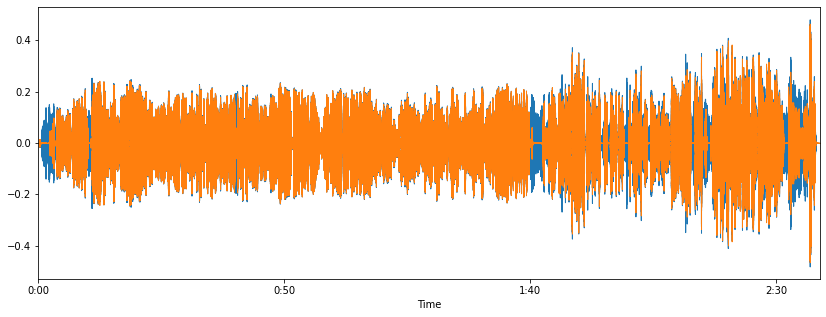

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(noisy.numpy(), sr=16000)
librosa.display.waveplot(estimate.numpy(), sr=16000)